In [1]:
#Initialization
using Pkg
using LinearAlgebra
using OrdinaryDiffEq
using Plots
using StatsBase
using ReferenceFrameRotations
theme(:dracula)

# Numerically Solving the N(=3)-Body Problem
----

## Scope: 
Here, we want to numerically integrate the 3-body problem trying to use orbital elements.

## Strategy:
 -We'll start by making a function that will get the initial conditions from the parameters. We'll be using the absolute coordinates. This one is actually portable with some effort to an N-body problem 
 
 -Then, we'll integrate it using Julia's beautiful libraries. 
 
 -Finally, we should do some rotations and representations
 
 -If we have time, we'll do some calculations after

---
## Kepler-16 System
The parameters we will use are those of the Kepler-16 system, https://en.wikipedia.org/wiki/Kepler-16 for more info. The basic jist is that it is a binary star system orbited by a planet, and it produces a very interesting gif!

---

## Initial Values
I'm not going to lie, this is by far the part that took the most time, sweat, blood and horrible dumb mistakes to implement. Units are very important, and for at least 4 hours things weren't working at all; I had copied $G$ in $(pc) (km/s)^2$ units instead of standard astronimcal units. It was devastating. Regardless of that We basically enforce that the center of mass must be in (0,0), and do everything in our power to mantain that. This is somewhat trivial for the two-body problem, requires a lot more finesse for the 3 body, and **I** don't think there's a general way to implement this. Maybe someone smarter than me has found it. We also implement our rotation function; it basically takes a vector and 3 Euler angles and spits out the vector in the observer frame.



In [7]:
M = [0.2026,0.6897,0.0123] #Should be given in solar units
G=39.478 # AU³ yr⁻² Mₒ⁻¹
M = G * M
Ω = 0
iₐ = 90.304*pi/180
ω = 263.464*pi/180
#e = 0.0069
#a =  (P/(2pi) *sum(M))^(2/3)
T = 10 # Integration parameters. This is the time it'll integrate on
dT = 1e-3 # This is the time-steps it'll take
const n = 3 #Number of bodies

#--------------------------------------------------Functions to set Initial Conditions and rotate us into the observer frame-----------------------------------------------------------------#

function InitialConditions(a, e, m1, m2)
    μ =(m1 + m2)
    
    r = a * (1 - e^2) / (1 + e)
    v = sqrt(μ*(2/r - 1/a))
    
    x1 = -m2/μ * r  
    y1 = 0  
    z1 = 0  
    vx1 = 0 
    vy1 = -m2/μ * v  
    vz1 = 0  
    
    x2 = m1/μ * r  
    y2 = 0 
    z2 = 0  
    vx2 = 0 
    vy2 = m1/μ * v  
    vz2 = 0
    
    return [[[x1, y1, z1], [x2, y2, z2]], [[vx1, vy1, vz1], [vx2, vy2, vz2]]]
end 
function RotateToObserver(r,  Ω, iₐ, ω)
    R_z = [cos(ω) sin(ω) 0;
           -sin(ω) cos(ω) 0;
           0 0 1]
    R_x = [1 0 0;
           0 cos(iₐ) sin(iₐ);
           0 -sin(iₐ) cos(iₐ)]
    R_z_2 = [cos(Ω) sin(Ω) 0;
             -sin(Ω) cos(Ω) 0;
             0 0 1] #I basically copied the rotation formulas from wikipedia here, but (Ω,i,ω) are just euler angles, so this shouldn't look too crazy
    return R_z * R_x * R_z_2 * r
end
#--------------------------------------------------Setting the initial conditions into the vectors we're gonna end up using. -----------------------------------------------------------------#

InitABPos, InitABVel= -InitialConditions(0.22,0.159,M[1],M[2])[1],InitialConditions(0.22,0.159,M[1],M[2])[2] 
InitCMCPos,InitCMCVel = InitialConditions(0.705,0.0069,M[1]+M[2],M[3])[1],InitialConditions(0.705,0.0069,M[1]+M[2],M[3])[2]
InitABPos,InitCMCPos
InitABPos = InitABPos + [InitCMCPos[1],InitCMCPos[1]]/2 #This is the 3-body problem problem. We gotta do this song and dance, and it basically boils down to center of massing things.
InitABVel = InitABVel + [InitCMCVel[1],InitCMCVel[1]]/2
push!(InitABPos,InitCMCPos[2])
push!(InitABVel,InitCMCVel[2])


r0 = transpose(reduce(vcat,InitABPos)) #Whenever you see one of these hateful transpose(reduce(vcat,...)), it's basically the way I have to translate between Vectors of Vectors into the stuff
v0 = transpose(reduce(vcat,InitABVel)) # That our integrator can understand



1×9 transpose(::Vector{Float64}) with eltype Float64:
 0.0  -11.5306  0.0  0.0  3.3241  0.0  0.0  7.06907  0.0

## Integrating
Here, we define our acceleration (The Kepler function). It uses a lot of demon-worship because I'm kind of stupid; Initially I made it take a vector of n(=2) vectors (i.e. $r=(\vec r_a,\vec r_b)$) and output the same type of object. This was, however, a bad idea, because ODEDiffEqs absolutely cannot handle or understand it. The demonic stuff is where I 'flatten' my n(=2) vectors for inputting, unflatten it for the function, and flatten it again for the output. I could have probably done this in a cleaner, better and more efficient way, but I was emotionally attached to this (and now my code probably runs unimaginably slower)

Having said all of that, I then just do the standard ODE stuff: Set it up as a 'problem', solve it. At first, I was using SymplecticEuler(), but I was convinced that McAte2(), a second order symplectic integrator, was both more accurate and faster for this problem. Now, just so I don't forget to mention it, the solution itself (stored in the ```Solved``` variable) is basically a time-series 18-dimensional array, 9 velocity coordinates and 9 position coordinates. It is unwieldy to work with, so we'll have to make it workable.

In [8]:
function Kepler(dq,q,m,t) 
    ans= [Float64[0,0,0]]
    for k ∈ 1:n-1
        push!(ans,Float64[0,0,0])
    end
  
    r = ans
    for i ∈ 1:n
        r[i] = q[1+3*(i-1):3*i]
    end
    ans= [Float64[0,0,0]]
    for k ∈ 1:n-1
        push!(ans,Float64[0,0,0])
    end
    for i ∈ 1:n 
        for j ∈ 1:n
            if i != j
                R = r[i]-r[j]
                ans[i]= ans[i] - m[j]/(norm(R)^3) * (R[1:3])
            end
        end
    end
    return transpose(reduce(vcat,ans))
end 
ProblemKepler = SecondOrderODEProblem(Kepler,v0,r0,(0,T),M)
Solved = solve(ProblemKepler,dt=dT,McAte2(),progress=true)
#plot(Solved, vars=(10,11,12))
#Kepler(0.0,r0,M,0.0)
println("🍔")
#Kepler(0.0,transpose(reduce(vcat,symmetricinitpos)),M,0.0)


🍔


----
# Representing our simulation

## Paying for my sins
Now, we gotta untangle everything and get somewhat understandable and interpretable vectors. We'll get them, make sure that they are in CM coordinates, and also get them rotated into the observer frame. We'll represent them separately, and finally produce some great gifs

Rcm = Rcm / sum(M) = [0.004695209128015288 0.004695209128015288 0.004695209128015284 0.004695209128015278 0.004695209128015284 0.004695209128015274 0.004695209128015282 0.0046952091280152795 0.004695209128015276 0.004695209128015272 0.00469520912801528 0.004695209128015278 0.0046952091280152795 0.004695209128015274 0.004695209128015278 0.004695209128015276 0.004695209128015276 0.004695209128015276 0.004695209128015272 0.004695209128015271 0.004695209128015272 0.004695209128015268 0.004695209128015269 0.004695209128015267 0.0046952091280152665 0.004695209128015266 0.004695209128015265 0.004695209128015264 0.004695209128015262 0.004695209128015262 0.00469520912801526 0.004695209128015258 0.004695209128015256 0.004695209128015258 0.004695209128015254 0.004695209128015253 0.00469520912801526 0.004695209128015262 0.004695209128015266 0.004695209128015262 0.004695209128015256 0.00469520912801527 0.004695209128015266 0.004695209128015256 0.004695209128015264 0.004695209128015253 0.00469520912

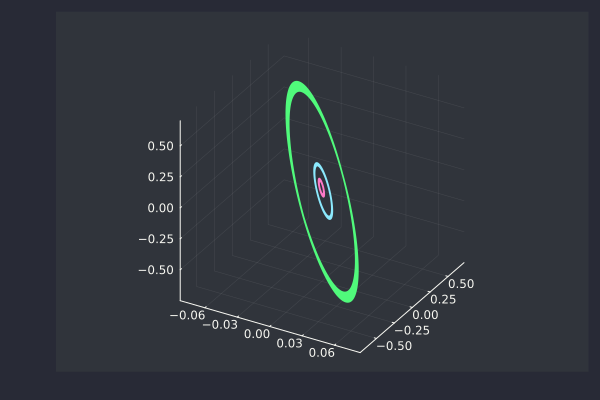

In [9]:

R= []
for i ∈ 1:n
    push!(R,Solved[3(n+i-1)+1:3(n+i-1)+3,:])
end
Rcm = M[1]*R[1]
for i ∈ 2:n
    Rcm = Rcm + M[i]R[i]
end
Rcm = Rcm/sum(M)

Rcenter=[]
for i ∈ 1:n
    push!(Rcenter,R[i] - Rcm)
end

Rotated=[]
for j ∈ 1:n
    push!(Rotated,RotateToObserver(Rcenter[j],  Ω, iₐ, ω))
end
plot(Rotated[1][1,:],Rotated[1][2,:],Rotated[1][3,:],linewidth=1.2,legend=false)
plot!(Rotated[2][1,:],Rotated[2][2,:],Rotated[2][3,:],linewidth=1.2,legend=false)
plot!(Rotated[3][1,:],Rotated[3][2,:],Rotated[3][3,:],linewidth=1.2,legend=false)


## The Payoff
Now, we just use Julia's beautiful graphing tools to make some graphs.

[ Info: Saved animation to c:\Users\batti\Documents\Uni\ComputationalProjects\Julia\AstroPhysics\tmp.gif


Plots.AnimatedGif("c:\\Users\\batti\\Documents\\Uni\\ComputationalProjects\\Julia\\AstroPhysics\\tmp.gif")
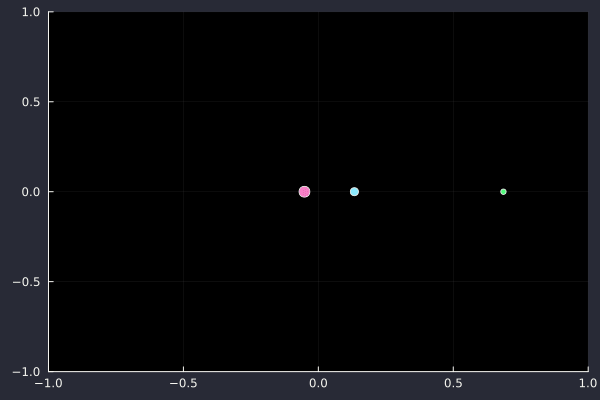

In [10]:

max=1
Time = trunc(Int64,T/dT)
frames =  trunc(Int64,Time/3000)
size = 3*[1.5,2,1]
trail = 10*frames
@gif for i ∈ 1:frames:Time
    plt = plot(xlim=[-max,max],ylim=[-max,max],zlim=[-max,max],markerstrokewidth=0,camera=(45+0.0001*i,45),background_color_inside=RGB(0,0,0),legends=false)
    for j ∈ 1:3
    scatter!(plt,Rcenter[j][1,i:i],Rcenter[j][2,i:i],markersize=size[j])
    i > trail ? plot!(Rcenter[j][1,i-trail:i],Rcenter[j][2,i-trail:i]) : nothing
    end
end

[ Info: Saved animation to c:\Users\batti\Documents\Uni\ComputationalProjects\Julia\AstroPhysics\tmp.gif


Plots.AnimatedGif("c:\\Users\\batti\\Documents\\Uni\\ComputationalProjects\\Julia\\AstroPhysics\\tmp.gif")
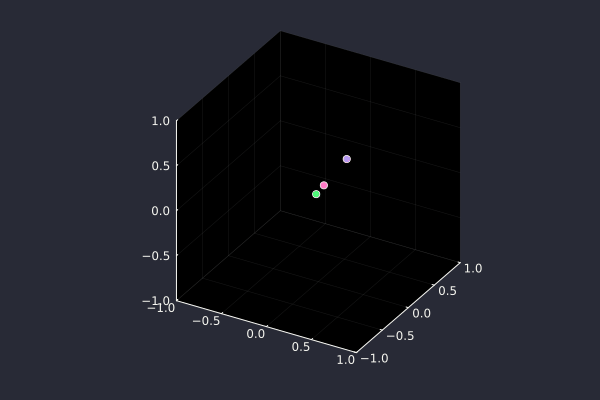

In [11]:
@gif for i ∈ 1:frames:Time
    plot3d([],xlim=[-max,max],ylim=[-max,max],zlim=[-max,max],markerstrokewidth=0,markersize=5,legend=false,background_color_inside=RGB(0,0,0))
    for j ∈ 1:n
        scatter3d!(Rotated[j][1,i:i],Rotated[j][2,i:i],Rotated[j][3,i:i])
        i > trail ? plot3d!(Rotated[j][1,i-trail:i],Rotated[j][2,i-trail:i],Rotated[j][3,i-trail:i]) : nothing
        i > trail ? plot3d!(Rotated[j][1,i-trail:i],Rotated[j][2,i-trail:i],Rotated[j][3,i-trail:i]) : nothing

    end
end